## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [6]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [7]:
train, test = keras.datasets.cifar10.load_data()

In [8]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [9]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [15]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import BatchNormalization, Activation

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-8, 1e-12]
L2_EXP = [1e-8, 1e-12]
BATCH_SIZE = [64, 128]

In [16]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, (l1r, l2r, bz) in enumerate(itertools.product(L1_EXP, L2_EXP, BATCH_SIZE)):
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=bz, 
          validation_data=(x_test, y_test), 
          shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    # Collect results
    exp_name_tag = "exp-l1-%s-l2-%s-bz-%s" % (str(l1r), str(l2r), str(bz))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
__________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 26s 521us/step - loss: 1.6290 - acc: 0.4198 - val_loss: 1.6678 - val_acc: 0.3953
Epoch 2/10
50000/50000 [==============================] - 24s 481us/step - loss: 1.4076 - acc: 0.4978 - val_loss: 1.7602 - val_acc: 0.3829
Epoch 3/10
50000/50000 [==============================] - 24s 481us/step - loss: 1.2962 - acc: 0.5370 - val_loss: 1.6950 - val_acc: 0.4148
Epoch 4/10
50000/50000 [==============================] - 24s 484us/step - loss: 1.2140 - acc: 0.5679 - val_loss: 1.8360 - val_acc: 0.3685
Epoch 5/10
50000/50000 [==============================] - 25s 496us/step - loss: 1.1391 - acc: 0.5936 - val_loss: 1.6028 - val_acc: 0.4599
Epoch 6/10
50000/50000 [==============================] - 25s 500us/step - loss: 1.0722 - acc: 0.6172 - val_loss: 1.5289 - val_acc: 0.4703
Epoch 7/10
50000/50000 [==============================] - 25s 492us/step - loss: 1.0066 - acc: 0.6415 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 18s 354us/step - loss: 1.6100 - acc: 0.4274 - val_loss: 1.9880 - val_acc: 0.2979
Epoch 2/10
50000/50000 [==============================] - 16s 310us/step - loss: 1.3771 - acc: 0.5081 - val_loss: 1.7155 - val_acc: 0.3604
Epoch 3/10
50000/50000 [==============================] - 15s 306us/step - loss: 1.2651 - acc: 0.5507 - val_loss: 1.5492 - val_acc: 0.4487
Epoch 4/10
50000/50000 [==============================] - 15s 307us/step - loss: 1.1745 - acc: 0.5816 - val_loss: 1.6173 - val_acc: 0.4264
Epoch 5/10
50000/50000 [==============================] - 15s 308us/step - loss: 1.0926 - acc: 0.6133 - val_loss: 1.6137 - val_acc: 0.4319
Epoch 6/10
50000/50000 [==============================] - 15s 309us/step - loss: 1.0247 - acc: 0.6363 - val_loss: 1.6893 - val_acc: 0.4353
Epoch 7/10
50000/50000 [==============================] - 16s 314us/step - loss: 0.9468 - acc: 0.6663 - val_loss: 1.

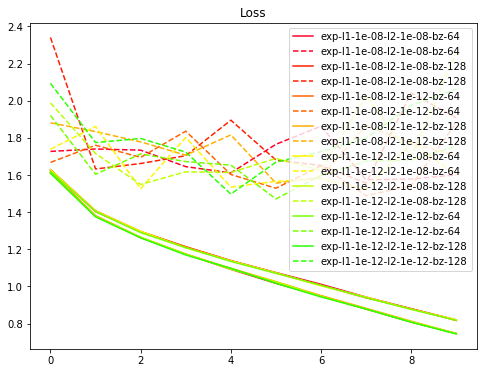

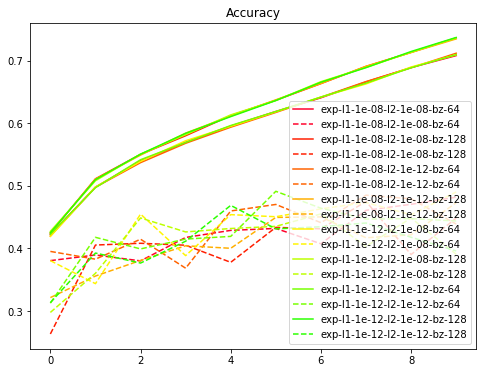

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()